# Analyse complète : Séismes & Prix Immobiliers aux États-Unis  
Ce notebook regroupe :
- Deux cartes US (séismes & prix immobiliers)
- Un scatter avec régression
- Une analyse High/Low n_earthquake groupée
- Une visualisation centrée (taille de points)

In [1]:
import pandas as pd
import numpy as np
import altair as alt

# Load dataset
agg_county_year = pd.read_parquet("data/agg_county_year.parquet")
agg_state_year = pd.read_parquet("data/agg_state_year.parquet")

# --- Fill NaN only for numeric columns ---
for df in [agg_county_year, agg_state_year]:
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(0)

# agg_county_year, agg_state_year

### Chargement données pour la carte

In [2]:
from vega_datasets import data
# ---------------------------
# LOAD US STATES TOPOJSON
# ---------------------------
us_states = alt.topo_feature(data.us_10m.url, "states")

# ---------------------------
# FIPS TO INT
# ---------------------------
agg_state_year['state_fips'] = agg_state_year['state_fips'].astype(int)
agg_county_year['state_fips'] = agg_county_year['state_fips'].astype(int)
agg_county_year['county_fips'] = agg_county_year['county_fips'].astype(str).str.zfill(5)  # garde pour counties

# agg_county_year
# agg_state_year

## Sélection de l’année

In [3]:
year = 2015
agg_state_year_chosen = agg_state_year[agg_state_year["year"] == year]
agg_county_year_chosen = agg_county_year[agg_county_year["year"] == year]

# print(agg_state_year_chosen.head(), df_county_aggreg_year.head())

# Carte US : Intensité des Séismes et Prix Médian des Maisons

In [4]:
heatmap_year_eq = alt.Chart(us_states).mark_geoshape().encode(
    color=alt.Color(
        "n_earthquakes:Q",
        scale=alt.Scale(range=["#ffe6e6", "#800000"]),
        title="Number of earthquake"
    ),
    tooltip=["state:N", "n_earthquakes:Q"]
).transform_lookup(
    lookup="id",
    from_=alt.LookupData(agg_state_year.dropna(subset=["n_earthquakes"]), "state_fips", ["n_earthquakes", "state"])
).project("albersUsa").properties(
    title="USA earthquake map", width=400, height=300
)

heatmap_year_price = alt.Chart(us_states).mark_geoshape().encode(
    color=alt.Color(
        "avg_price:Q",
        scale=alt.Scale(range=["#e6f2ff", "#0055aa"]),
        title="Average real estate price"
    ),
    tooltip=["state:N", "avg_price:Q"]
).transform_lookup(
    lookup="id",
    from_=alt.LookupData(agg_state_year.dropna(subset=["avg_price"]), "state_fips", ["avg_price", "state"])
).project("albersUsa").properties(
    title="USA Average real estate price", width=400, height=300
)

heatmap_eq = alt.Chart(us_states).mark_geoshape().encode(
    color=alt.Color(
        "n_earthquakes:Q",
        scale=alt.Scale(range=["#ffe6e6", "#800000"]),
        title="Number of earthquake"
    ),
    tooltip=["state:N", "n_earthquakes:Q"]
).transform_lookup(
    lookup="id",
    from_=alt.LookupData(agg_state_year_chosen.dropna(subset=["n_earthquakes"]), "state_fips", ["n_earthquakes", "state"])
).project("albersUsa").properties(
    title=f"USA earthquake map ({year})", width=400, height=300
)

heatmap_price = alt.Chart(us_states).mark_geoshape().encode(
    color=alt.Color(
        "avg_price:Q",
        scale=alt.Scale(range=["#e6f2ff", "#0055aa"]),
        title="Average real estate price"
    ),
    tooltip=["state:N", "avg_price:Q"]
).transform_lookup(
    lookup="id",
    from_=alt.LookupData(agg_state_year_chosen.dropna(subset=["avg_price"]), "state_fips", ["avg_price", "state"])
).project("albersUsa").properties(
    title=f"USA Average real estate price ({year})", width=400, height=300
)

maps = (heatmap_year_eq | heatmap_year_price).resolve_scale(color="independent")
maps

alt.HConcatChart(...)

# Corrélation Séismes ↔ Prix

## 🔎 Analyse de la Relation entre l’Activité Sismique et les Prix Immobiliers  
### Une visualisation combinant échelle logarithmique, intensité sismique et tendance générale

Cette visualisation explore comment le nombre de séismes dans un État américain est associé au prix médian de l’immobilier.  
Elle combine plusieurs éléments complémentaires :

- **Scatter plot** : chaque point représente un État pour l’année sélectionnée.  
- **Échelle logarithmique sur l’axe des X** : permet de visualiser correctement des niveaux de sismicité très différents (de 1 à plusieurs centaines).  
- **Couleur continue (Viridis)** : encode l’intensité des séismes, renforçant la lecture des variations.  
- **Regression Linéaire** : une tendance linéaire qui met en évidence la relation générale.  

L’objectif final est d’offrir une lecture claire, équilibrée et robuste de la relation potentielle entre l’activité sismique et les prix domiciliaires, malgré la grande variabilité des États.

In [5]:
# Filter out invalid values
df_corr = agg_state_year_chosen[
    (agg_state_year_chosen["n_earthquakes"] > 0) &
    (agg_state_year_chosen["avg_price"] > 0)
].copy()

# Ensure numeric
df_corr["n_earthquakes"] = pd.to_numeric(df_corr["n_earthquakes"], errors="coerce")
df_corr["avg_price"] = pd.to_numeric(df_corr["avg_price"], errors="coerce")

# Color scale
color_scale = alt.Scale(type="log", scheme="viridis")

scatter = (
    alt.Chart(df_corr)
    .mark_circle(size=90, opacity=0.75)
    .encode(
        x=alt.X("n_earthquakes:Q", title="Earthquakes (log scale)", scale=alt.Scale(type="log")),
        y=alt.Y("avg_price:Q", title="Average House Price ($)", scale=alt.Scale(zero=False)),
        color=alt.Color("n_earthquakes:Q", title="Earthquake Count", scale=color_scale,
                        legend=alt.Legend(labelExpr="datum.label")),
        tooltip=[
            alt.Tooltip("state:N"),
            alt.Tooltip("n_earthquakes:Q", title="Earthquakes"),
            alt.Tooltip("avg_price:Q", title="Avg Price ($)")
        ]
    )
)

smooth = (
    alt.Chart(df_corr)
    .transform_regression("n_earthquakes", "avg_price", method="linear")
    .mark_line(color="black", size=3)
    .encode(
        x=alt.X("n_earthquakes:Q", scale=alt.Scale(type="log")),
        y="avg_price:Q"
    )
)

correlation = (scatter + smooth).properties(
    width=900,
    height=550,
    title="Earthquake Frequency vs House Prices (Log Scale)"
)

correlation

alt.LayerChart(...)

In [6]:
import altair as alt
import pandas as pd
import numpy as np

# --------------------------
# 1. FILTER AND CLEAN DATA
# --------------------------

df_corr = agg_state_year_chosen[
    (agg_state_year_chosen["n_earthquakes"] > 0) &
    (agg_state_year_chosen["avg_price"] > 0) &
    (agg_state_year_chosen["avg_magnitude"].notna())
].copy()

# Ensure numeric
df_corr["n_earthquakes"] = pd.to_numeric(df_corr["n_earthquakes"], errors="coerce")
df_corr["avg_price"] = pd.to_numeric(df_corr["avg_price"], errors="coerce")
df_corr["avg_magnitude"] = pd.to_numeric(df_corr["avg_magnitude"], errors="coerce")

# --------------------------
# 2. CREATE DYNAMIC EXCLUSIVE BINS
# --------------------------

# Determine min and max for avg_magnitude
min_mag = df_corr["avg_magnitude"].min()
max_mag = df_corr["avg_magnitude"].max()

# Create 5 equal-width bins between min and max
bins = np.linspace(min_mag, max_mag, num=6)  # 6 edges → 5 bins
labels = [f"{round(bins[i],1)}-{round(bins[i+1],1)}" for i in range(len(bins)-1)]

# right=False ensures exclusive upper boundary
df_corr["magnitude_bin"] = pd.cut(df_corr["avg_magnitude"], bins=bins, labels=labels, right=False)

# --------------------------
# 3. DEFINE DARK COLOR SCALE
# --------------------------

color_scale = alt.Scale(
    domain=labels,
    range=["#7f3c8d", "#11a579", "#3969ac", "#f2b701", "#e73f74"]  # dark, distinct
)

# --------------------------
# 4. SCATTER PLOT
# --------------------------

scatter = (
    alt.Chart(df_corr)
    .mark_circle(size=90, opacity=0.75)
    .encode(
        x=alt.X("n_earthquakes:Q", title="Earthquakes (log scale)", scale=alt.Scale(type="log")),
        y=alt.Y("avg_price:Q", title="Average House Price ($)", scale=alt.Scale(zero=False)),
        color=alt.Color("magnitude_bin:N", title="Avg Magnitude Bin", scale=color_scale),
        tooltip=[
            alt.Tooltip("state:N"),
            alt.Tooltip("n_earthquakes:Q", title="Earthquakes"),
            alt.Tooltip("avg_price:Q", title="Avg Price ($)"),
            alt.Tooltip("avg_magnitude:Q", title="Avg Magnitude"),
            alt.Tooltip("magnitude_bin:N", title="Magnitude Bin")
        ]
    )
)

# --------------------------
# 5. REGRESSION TRENDLINE
# --------------------------

smooth = (
    alt.Chart(df_corr)
    .transform_regression("n_earthquakes", "avg_price", method="linear")
    .mark_line(color="black", size=3)
    .encode(
        x=alt.X("n_earthquakes:Q", scale=alt.Scale(type="log")),
        y="avg_price:Q"
    )
)

# --------------------------
# 6. COMBINE PLOT
# --------------------------

correlation = (scatter + smooth).properties(
    width=900,
    height=550,
    title="Earthquake Frequency vs House Prices (Log Scale, Dynamic Magnitude Bins)"
)

correlation


alt.LayerChart(...)

# Classification des États : High vs Low n_earthquake
Seuls les États dans les quantiles 20% et 80% sont conservés.

In [7]:
# Sum of earthquakes per state
state_totals = agg_state_year_chosen.groupby('state')['n_earthquakes'].sum().sort_values()

threshold_high = state_totals.quantile(0.8)
threshold_low = state_totals.quantile(0.2)

def classify_state(state):
    total = state_totals[state]
    if total >= threshold_high:
        return 'High n_earthquake'
    elif total <= threshold_low:
        return 'Low n_earthquake'
    else:
        return 'Medium'

# Apply classification
agg_state_year_chosen['quake_group'] = agg_state_year_chosen['state'].apply(classify_state)

# Select only high and low groups
df_selected = agg_state_year_chosen[agg_state_year_chosen['quake_group'].isin(['High n_earthquake', 'Low n_earthquake'])]

# df_selected.head()

/var/folders/lq/3djnzdbx6ll0000lzlm2th6w0000gn/T/ipykernel_51271/3017478637.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_state_year_chosen['quake_group'] = agg_state_year_chosen['state'].apply(classify_state)


# Evolution des prix selon High / Low n_earthquake

In [8]:
import altair as alt
import pandas as pd

# --- Filter data after 1990 ---
df_state_aggreg_filtered = agg_state_year[agg_state_year['year'] > 1990].copy()

# Y-axis domain
buffer = 1_000_000
ymin = df_state_aggreg_filtered['avg_price'].min()
ymax = df_state_aggreg_filtered['avg_price'].max() - buffer

# --- Clip scatter points within domain ---
df_state_aggreg_filtered = df_state_aggreg_filtered[
    (df_state_aggreg_filtered['avg_price'] >= ymin) &
    (df_state_aggreg_filtered['avg_price'] <= ymax)
].copy()

# --- Separate Alaska & California ---
df_alaska = df_state_aggreg_filtered[df_state_aggreg_filtered['state'] == 'Alaska']
df_california = df_state_aggreg_filtered[df_state_aggreg_filtered['state'] == 'California']

# --- Scatter with variable size ---
scatter = (
    alt.Chart(df_state_aggreg_filtered)
    .mark_circle(opacity=0.7)
    .encode(
        x=alt.X('year:O', title='Year'),
        y=alt.Y('avg_price:Q', title='Average House Price ($)',
                scale=alt.Scale(domain=[ymin, ymax])),
        size=alt.Size('n_earthquakes:Q', title='Number of Earthquakes',
                      scale=alt.Scale(range=[30, 400])),
        color=alt.value("#999999"),  # scatter = neutral grey
        tooltip=['state:N', 'year:O', 'n_earthquakes:Q', 'avg_price:Q']
    )
)

# --- Lines with legend ---
line_data = pd.concat([df_alaska, df_california])
line_data['line_label'] = line_data['state']  # used for the legend

line = (
    alt.Chart(line_data)
    .mark_line(size=3)
    .encode(
        x='year:O',
        y='avg_price:Q',
        color=alt.Color(
            'line_label:N',
            title='States',
            scale=alt.Scale(
                domain=['Alaska', 'California'],
                range=['#1f77b4', '#d62728']  # blue, red
            )
        ),
        tooltip=['state:N', 'year:O', 'avg_price:Q']
    )
)

# --- Combine ---
chart = (
    (scatter + line)
    .properties(
        width=900,
        height=500,
        title='House Prices Over Time – Alaska vs California (After 1990)'
    )
    .configure_axis(
        labelFontSize=12,
        titleFontSize=14,
        gridOpacity=0.2
    )
    .configure_legend(
        titleFontSize=14,
        labelFontSize=13,
        symbolSize=150
    )
    .configure_title(
        fontSize=18,
        anchor='start'
    )
)

chart

alt.LayerChart(...)

In [9]:
import altair as alt
import numpy as np

# --------------------------
# 1. CLEAN DATA
# --------------------------

df_corr = agg_state_year.copy()

# Remove invalid values
df_corr = df_corr[
    (df_corr["n_earthquakes"] > 0) &
    (df_corr["avg_price"] > 0)
].copy()

# Add log value for regression
df_corr["log_eq"] = np.log(df_corr["n_earthquakes"])

# --------------------------
# 2. SCATTER (log scale)
# --------------------------

color_scale = alt.Scale(scheme="viridis")

scatter_all = (
    alt.Chart(df_corr)
    .mark_circle(size=90, opacity=0.6)
    .encode(
        x=alt.X(
            "n_earthquakes:Q",
            title="Earthquakes (log scale)",
            scale=alt.Scale(type="log"),
            axis=alt.Axis(format="~s")
        ),
        y=alt.Y(
            "avg_price:Q",
            title="Median House Price ($)",
            scale=alt.Scale(zero=False, padding=10)
        ),
        color=alt.Color(
            "log_eq:Q",
            title="Earthquakes (log)",
            scale=color_scale
        ),
        tooltip=[
            alt.Tooltip("state:N", title="State"),
            alt.Tooltip("year:O", title="Year"),
            alt.Tooltip("n_earthquakes:Q", title="Earthquakes"),
            alt.Tooltip("avg_price:Q", title="House Price ($)")
        ]
    )
)

# --------------------------
# 3. TRENDLINE with log transform
# --------------------------

smooth_all = (
    alt.Chart(df_corr)
    .transform_regression(
        "log_eq", "avg_price"
    )
    .mark_line(
        color="black",
        size=3
    )
    .encode(
        x=alt.X(
            "n_earthquakes:Q",
            scale=alt.Scale(type="log")
        ),
        y="avg_price:Q"
    )
)

# --------------------------
# 4. COMBINE BOTH
# --------------------------

correlation_all = (
    (scatter_all + smooth_all)
    .properties(
        width=900,
        height=550,
        title="Relationship between Earthquake Frequency and House Prices (All Years, Log Scale)"
    )
    .configure_axis(
        gridOpacity=0.20,
        labelFontSize=12,
        titleFontSize=14
    )
    .configure_title(
        fontSize=22,
        anchor="start"
    )
)

correlation_all

alt.LayerChart(...)

In [10]:
import altair as alt
import numpy as np
import pandas as pd

# --------------------------
# 1. CLEAN DATA
# --------------------------

df_corr = agg_state_year.copy()

# Remove invalid values
df_corr = df_corr[
    (df_corr["n_earthquakes"] > 0) &
    (df_corr["avg_price"] > 0) &
    (df_corr["avg_magnitude"].notna())
].copy()

# Add log value for regression
df_corr["log_eq"] = np.log(df_corr["n_earthquakes"])

# --------------------------
# 2. CREATE DYNAMIC EXCLUSIVE BINS
# --------------------------

# Determine min and max of avg_magnitude
min_mag = df_corr["avg_magnitude"].min()
max_mag = df_corr["avg_magnitude"].max()

# Create 5 equal-width bins
bins = np.linspace(min_mag, max_mag, num=6)  # 6 edges → 5 bins
labels = [f"{round(bins[i],1)}-{round(bins[i+1],1)}" for i in range(len(bins)-1)]

# right=False ensures upper boundary is exclusive
df_corr["magnitude_bin"] = pd.cut(df_corr["avg_magnitude"], bins=bins, labels=labels, right=False)

# --------------------------
# 3. SCATTER WITH DARK COLORS
# --------------------------

color_scale = alt.Scale(
    domain=labels,
    range=["#7f3c8d", "#11a579", "#3969ac", "#f2b701", "#e73f74"]  # dark, distinct
)

scatter_all = (
    alt.Chart(df_corr)
    .mark_circle(size=90, opacity=0.7)
    .encode(
        x=alt.X(
            "n_earthquakes:Q",
            title="Earthquakes (log scale)",
            scale=alt.Scale(type="log"),
            axis=alt.Axis(format="~s")
        ),
        y=alt.Y(
            "avg_price:Q",
            title="Median House Price ($)",
            scale=alt.Scale(zero=False, padding=10)
        ),
        color=alt.Color(
            "magnitude_bin:N",
            title="Avg Magnitude Bin",
            scale=color_scale
        ),
        tooltip=[
            alt.Tooltip("state:N", title="State"),
            alt.Tooltip("year:O", title="Year"),
            alt.Tooltip("n_earthquakes:Q", title="Earthquakes"),
            alt.Tooltip("avg_price:Q", title="House Price ($)"),
            alt.Tooltip("avg_magnitude:Q", title="Avg Magnitude"),
            alt.Tooltip("magnitude_bin:N", title="Magnitude Bin")
        ]
    )
)

# --------------------------
# 4. TRENDLINE
# --------------------------

smooth_all = (
    alt.Chart(df_corr)
    .transform_regression("log_eq", "avg_price")
    .mark_line(color="black", size=3)
    .encode(
        x=alt.X("n_earthquakes:Q", scale=alt.Scale(type="log")),
        y="avg_price:Q"
    )
)

# --------------------------
# 5. COMBINE BOTH
# --------------------------

correlation_all = (
    (scatter_all + smooth_all)
    .properties(
        width=900,
        height=550,
        title="Earthquake Frequency vs House Prices (Dynamic Magnitude Bins)"
    )
    .configure_axis(
        gridOpacity=0.20,
        labelFontSize=12,
        titleFontSize=14
    )
    .configure_title(
        fontSize=22,
        anchor="start"
    )
    .configure_legend(
        titleFontSize=14,
        labelFontSize=13,
        symbolSize=150
    )
)

correlation_all



alt.LayerChart(...)

# Focus sur un Californie et Alaska

In [65]:
# Filtrer Alaska + California
df_state_AC = agg_state_year[agg_state_year["state"].isin(["Alaska", "California"])].copy()
df_state_AC = df_state_AC[df_state_AC["year"]>1999]
df_state_AC = df_state_AC[df_state_AC["year"]<2023]
df_county_AC = (
    agg_county_year[agg_county_year["state"].isin(["Alaska", "California"])].copy()
    .groupby(['state', 'county', 'county_fips'], as_index=False)
    .agg(
        avg_price=('avg_price', 'mean'),       # moyenne du prix
        n_earthquakes=('n_earthquakes', 'sum')  # somme des tremblements
    )
)

df_state_AC.to_parquet("data/df_state_AC.parquet", index=False)
print("✔ Saved improved Alaska-Californie filter df → df_state_AC.parquet")
df_county_AC.to_parquet("data/df_county_AC.parquet", index=False)
print("✔ Saved improved Alaska-Californie filter df → df_county_AC.parquet")

✔ Saved improved Alaska-Californie filter df → df_state_AC.parquet
✔ Saved improved Alaska-Californie filter df → df_county_AC.parquet


In [12]:
import altair as alt
import pandas as pd

# ============================================================
# FILTER + PREPARE DATA
# ============================================================
df = df_state_AC[
    (df_state_AC["state"].isin(["Alaska", "California"])) &
    (df_state_AC["year"] >= 1990) &
    (df_state_AC["n_earthquakes"] > 0) &
    (df_state_AC["avg_price"] > 0)
].copy()

df["avg_price_million"] = df["avg_price"] / 1e6

# ============================================================
# BASE COLOR SCALE
# ============================================================
color_scale = alt.Scale(
    domain=["Alaska", "California"],
    range=["#1f77b4", "#d62728"]
)

# ============================================================
# 1) EARTHQUAKE TIME SERIES
# ============================================================
eq_line = alt.Chart(df).mark_line().encode(
    x=alt.X("year:O", title="Year"),
    y=alt.Y("n_earthquakes:Q", title="Earthquakes"),
    color=alt.Color("state:N", scale=color_scale),
    tooltip=["state", "year", "n_earthquakes"]
)

eq_reg = alt.Chart(df).transform_regression(
    "year", "n_earthquakes", groupby=["state"]
).mark_line(strokeDash=[5,3]).encode(
    color=alt.Color("state:N", scale=color_scale)
)

# ============================================================
# 2) HOUSE PRICES
# ============================================================
price_line = alt.Chart(df).mark_line().encode(
    x="year:O",
    y=alt.Y("avg_price_million:Q", title="Avg Price (Million $)"),
    color=alt.Color("state:N", scale=color_scale),
    tooltip=["state", "year", "avg_price_million"]
)

price_reg = alt.Chart(df).transform_regression(
    "year", "avg_price_million", groupby=["state"]
).mark_line(strokeDash=[5,3]).encode(
    color=alt.Color("state:N", scale=color_scale)
)

# ============================================================
# 3) ANNOTATION 2008
# ============================================================
annotation = alt.Chart(pd.DataFrame({"year": [2008]})).mark_rule(
    stroke="gray",
    strokeDash=[4,4]
).encode(x="year:O")

# ============================================================
# 4) COMBINE PANELS
# ============================================================

# Alaska
ak_eq     = (eq_line + eq_reg + annotation).transform_filter(alt.datum.state == "Alaska") \
                                           .properties(title="Alaska – Earthquakes")
ak_price  = (price_line + price_reg + annotation).transform_filter(alt.datum.state == "Alaska") \
                                                 .properties(title="Alaska – House Prices")

# California
ca_eq     = (eq_line + eq_reg + annotation).transform_filter(alt.datum.state == "California") \
                                           .properties(title="California – Earthquakes")
ca_price  = (price_line + price_reg + annotation).transform_filter(alt.datum.state == "California") \
                                                 .properties(title="California – House Prices")

# Final 2×2 layout
final_chart = alt.vconcat(
    alt.hconcat(ak_eq, ca_eq),
    alt.hconcat(ak_price, ca_price)
).resolve_scale(
    color="independent",
    y="independent"
).properties(
    title="Alaska vs California – Earthquakes & House Prices (1990–2022)"
).configure_title(
    fontSize=20,
    anchor='start'
).configure_axis(
    labelFontSize=12,
    titleFontSize=13
)

final_chart

alt.VConcatChart(...)

In [14]:
import altair as alt
from vega_datasets import data

# --- Assure que county_fips est int pour le lookup ---
df_county_AC['county_fips'] = df_county_AC['county_fips'].astype(int)

counties = alt.topo_feature(data.us_10m.url, 'counties')
# ---------------------------
# 1) COUNTY EARTHQUAKE MAP
# ---------------------------
map_county_eq = (
    alt.Chart(counties)
    .mark_geoshape(stroke="white", strokeWidth=0.25)
    .encode(
        color=alt.Color(
            "n_earthquakes:Q",
            scale=alt.Scale(range=["#ffe6e6", "#800000"]),
            title="Number of Earthquakes"
        ),
        tooltip=[
            alt.Tooltip("state:N", title="State"),
            alt.Tooltip("county:N", title="County"),
            alt.Tooltip("n_earthquakes:Q", title="Earthquakes")
        ]
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(
            df_county_AC.dropna(subset=["n_earthquakes"]),
            "county_fips",
            ["n_earthquakes", "county", "state"]
        )
    )
    .project("albersUsa")
    .properties(
        title="County Earthquakes – Alaska & California",
        width=400,
        height=300
    )
)

# ---------------------------
# 2) COUNTY PRICE MAP
# ---------------------------
map_county_price = (
    alt.Chart(counties)
    .mark_geoshape(stroke="white", strokeWidth=0.25)
    .encode(
        color=alt.Color(
            "avg_price:Q",
            scale=alt.Scale(range=["#e6f2ff", "#003366"]),
            title="Average House Price ($)"
        ),
        tooltip=[
            alt.Tooltip("state:N", title="State"),
            alt.Tooltip("county:N", title="County"),
            alt.Tooltip("avg_price:Q", title="Avg Price")
        ]
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(
            df_county_AC.dropna(subset=["avg_price"]),
            "county_fips",
            ["avg_price", "county", "state"]
        )
    )
    .project("albersUsa")
    .properties(
        title="County Prices – Alaska & California",
        width=400,
        height=300
    )
)

# ---------------------------
# Combine side-by-side
# ---------------------------
final_maps = map_county_eq | map_county_price
final_maps.resolve_scale(color="independent")

alt.HConcatChart(...)

In [41]:
import altair as alt
from vega_datasets import data
import pandas as pd

# Assure que county_fips est int pour le lookup
df_county_AC['county_fips'] = df_county_AC['county_fips'].astype(int)

# ---------------------------
# 1) COUNTY PRICE MAP (Choropleth)
# ---------------------------
counties = alt.topo_feature(data.us_10m.url, 'counties')

map_county_price = (
    alt.Chart(counties)
    .mark_geoshape(stroke="white", strokeWidth=0.25)
    .encode(
        color=alt.Color(
            "avg_price:Q",
            scale=alt.Scale(range=["#C7CEF7", "#02147A"]),
            title="Average House Price ($)"
        ),
        tooltip=[
            alt.Tooltip("state:N", title="State"),
            alt.Tooltip("county:N", title="County"),
            alt.Tooltip("avg_price:Q", title="Avg Price", format="$,.0f")
        ]
    )
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(
            df_county_AC.dropna(subset=["avg_price"]),
            "county_fips",
            ["avg_price", "county", "state"]
        )
    )
    .project("albersUsa")
    .properties(
        title="County House Prices – Alaska & California",
        width=400,
        height=300
    )
)

# ---------------------------
# 2) SCATTERPLOT: Earthquakes vs Prices
# ---------------------------
# Filtrer et préparer les données pour le scatterplot
scatter_data = df_county_AC.dropna(subset=["n_earthquakes", "avg_price"]).copy()
scatter_data = scatter_data[scatter_data["avg_price"] != 0]

# Créer l'échelle de couleurs pour les états
color_scale = alt.Scale(
    domain=["Alaska", "California"],
    range=["#1f77b4", "#d62728"]
)

# Scatterplot de base
scatterplot = (
    alt.Chart(scatter_data)
    .mark_circle(size=60, opacity=0.7)
    .encode(
        x=alt.X(
            "n_earthquakes:Q",
            title="Number of Earthquakes",
            scale=alt.Scale(type="log" if scatter_data["n_earthquakes"].max() > 100 else "linear")
        ),
        y=alt.Y(
            "avg_price:Q",
            title="Average House Price ($)",
            scale=alt.Scale(zero=False)
        ),
        color=alt.Color("state:N", scale=color_scale, title="State"),
        tooltip=[
            alt.Tooltip("state:N", title="State"),
            alt.Tooltip("county:N", title="County"),
            alt.Tooltip("n_earthquakes:Q", title="Earthquakes"),
            alt.Tooltip("avg_price:Q", title="Avg Price", format="$,.0f")
        ]
    )
    .properties(
        title="Earthquakes vs House Prices by County",
        width=400,
        height=300
    )
)

# ---------------------------
# 3) AJOUTER LES LIGNES DE RÉGRESSION
# ---------------------------
regression = alt.Chart(scatter_data).transform_regression(
    "n_earthquakes", "avg_price", groupby=["state"]
).mark_line(strokeWidth=2, strokeDash=[5, 3]).encode(
    x="n_earthquakes:Q",
    y="avg_price:Q",
    color=alt.Color("state:N", scale=color_scale, legend=None)
)

# Combiner scatterplot et régression
scatterplot_with_regression = scatterplot + regression

# ---------------------------
# 4) COMBINE LES DEUX VISUALISATIONS
# ---------------------------
final_viz = alt.hconcat(map_county_price, scatterplot_with_regression)

# Ajouter un titre global
final_viz = final_viz.properties(
    title="County Analysis: House Prices and Earthquake Frequency"
).configure_title(
    fontSize=20,
    anchor='start'
).configure_axis(
    labelFontSize=12,
    titleFontSize=13
).configure_legend(
    titleFontSize=13,
    labelFontSize=12
)

# Afficher la visualisation
final_viz

alt.HConcatChart(...)

# Dernière Visualisation

In [20]:
import altair as alt
import pandas as pd

# --- Filter data between 1999 and 2022 ---
df = df_state_AC[
    (df_state_AC['year'] >= 1999) &
    (df_state_AC['year'] <= 2022)
].copy()

df = df.dropna(subset=["avg_price", "n_earthquakes"])

# --- Compute normalization for earthquakes ---
ymin = df["avg_price"].min()
ymax = df["avg_price"].max()

df["eq_norm"] = (
    (df["n_earthquakes"] - df["n_earthquakes"].min()) /
    (df["n_earthquakes"].max() - df["n_earthquakes"].min())
) * (ymax - ymin) + ymin

# ------------------------------------
# AXIS DEFINITIONS
# ------------------------------------
left_axis = alt.Axis(title="Average House Price ($)")
right_axis = alt.Axis(title="Earthquakes (normalized)", orient="right")

# ------------------------------------
# SCATTER (left axis)
# ------------------------------------
scatter = (
    alt.Chart(df)
    .mark_circle(opacity=0.6)
    .encode(
        x=alt.X("year:O", title="Year"),
        y=alt.Y("avg_price:Q", axis=left_axis),
        size=alt.Size("n_earthquakes:Q",
                      title="Number of Earthquakes",
                      scale=alt.Scale(range=[50, 600])),
        color=alt.Color("state:N",
                        scale=alt.Scale(
                            domain=["Alaska", "California"],
                            range=["#1f77b4", "#d62728"]
                        )),
        tooltip=["state", "year", "avg_price", "n_earthquakes"]
    )
)

# ------------------------------------
# EARTHQUAKE REGRESSION (right axis)
# ------------------------------------
reg_right = (
    alt.Chart(df)
    .transform_regression("year", "eq_norm", groupby=["state"])
    .mark_line(size=3, strokeDash=[6,3])
    .encode(
        x="year:O",
        y=alt.Y("eq_norm:Q", axis=right_axis),
        color=alt.Color(
            "state:N",
            scale=alt.Scale(
                domain=["Alaska", "California"],
                range=["#1f77b4", "#d62728"]
            ),
            legend=None
        ),
        tooltip=["state", "year", "n_earthquakes"]
    )
)

# ------------------------------------
# PRICE LINE (left axis)
# ------------------------------------
price_line = (
    alt.Chart(df)
    .mark_line(size=3)
    .encode(
        x="year:O",
        y=alt.Y("avg_price:Q"),
        color=alt.Color(
            "state:N",
            scale=alt.Scale(
                domain=["Alaska", "California"],
                range=["#1f77b4", "#d62728"]
            ),
            title="States"
        )
    )
)

# ------------------------------------
# FINAL CHART
# ------------------------------------
chart = (
    (scatter + price_line + reg_right)
    .properties(
        width=900,
        height=500,
        title="Housing Prices vs Earthquake Trend (1999–2022)"
    )
    .configure_axis(labelFontSize=12, titleFontSize=14)
    .configure_title(fontSize=18, anchor="start")
)

chart

alt.LayerChart(...)

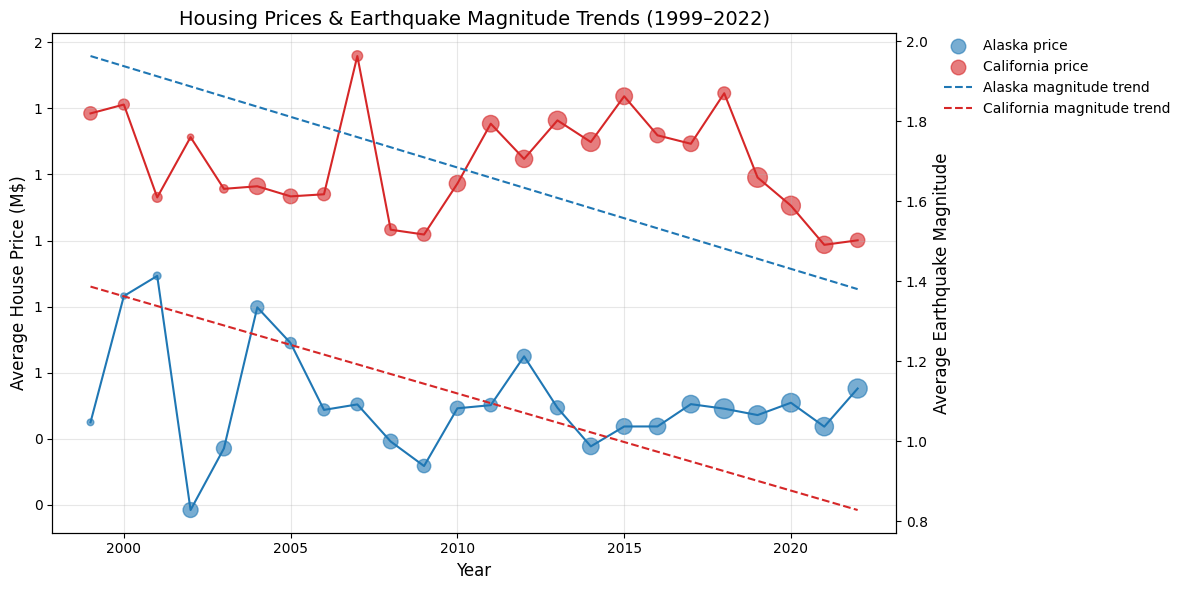

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter

# --- Filter data 1999-2022 ---
df = df_state_AC[(df_state_AC['year'] >= 1999) & (df_state_AC['year'] <= 2022)].copy()
df = df.dropna(subset=["avg_price", "n_earthquakes", "avg_magnitude"])

# --- Convert prices to millions ---
df['avg_price_million'] = df['avg_price'] / 1_000_000

# --- Separate states ---
df_alaska = df[df['state'] == 'Alaska']
df_california = df[df['state'] == 'California']

# --- Figure & axes ---
fig, ax_price = plt.subplots(figsize=(12,6))
ax_eq = ax_price.twinx()  # axe droit pour magnitude

# --- Scatter: avg_price vs year, size = n_earthquakes ---
max_marker = 200
min_marker = 20

for state_df, color in zip([df_alaska, df_california], ['#1f77b4', '#d62728']):
    sizes = min_marker + (state_df['n_earthquakes'] - state_df['n_earthquakes'].min()) / \
            (state_df['n_earthquakes'].max() - state_df['n_earthquakes'].min()) * (max_marker - min_marker)
    ax_price.scatter(
        state_df['year'],
        state_df['avg_price_million'],
        s=sizes,
        alpha=0.6,
        color=color,
        label=f"{state_df['state'].iloc[0]} price"
    )

# --- Lines: avg_price trends ---
for state_df, color in zip([df_alaska, df_california], ['#1f77b4', '#d62728']):
    ax_price.plot(
        state_df['year'],
        state_df['avg_price_million'],
        color=color,
        linewidth=1.5
    )

# --- Regression: avg_magnitude trend ---
for state_df, color in zip([df_alaska, df_california], ['#1f77b4', '#d62728']):
    X = state_df['year'].values.reshape(-1,1)
    y = state_df['avg_magnitude'].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    ax_eq.plot(
        state_df['year'],
        y_pred,
        color=color,
        linestyle='--',
        linewidth=1.5,
        label=f"{state_df['state'].iloc[0]} magnitude trend"
    )

# --- Axes labels ---
ax_price.set_ylabel("Average House Price (M$)", fontsize=12)
ax_eq.set_ylabel("Average Earthquake Magnitude", fontsize=12)
ax_price.set_xlabel("Year", fontsize=12)
ax_price.set_title("Housing Prices & Earthquake Magnitude Trends (1999–2022)", fontsize=14)

# --- Format Y axis (millions) ---
ax_price.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))

# --- Legends ---
lines, labels = ax_price.get_legend_handles_labels()
lines2, labels2 = ax_eq.get_legend_handles_labels()
all_lines = lines + lines2
all_labels = labels + labels2

ax_price.legend(
    all_lines,
    all_labels,
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0.,
    fontsize=10,
    frameon=False
)

# --- Grid & layout ---
ax_price.grid(alpha=0.3)
ax_price.tick_params(axis='both', which='major', labelsize=10)
ax_eq.tick_params(axis='y', labelsize=10)
fig.tight_layout()

plt.show()

In [58]:
import altair as alt
import pandas as pd
import numpy as np

# ============================================================
# PRÉPARATION DES DONNÉES
# ============================================================
# Filtrer les données pour Alaska et California
df = df_state_AC[
    (df_state_AC["state"].isin(["Alaska", "California"])) &
    (df_state_AC["year"] >= 1990) &
    (df_state_AC["n_earthquakes"] > 0) &
    (df_state_AC["avg_price"] > 0)
].copy()

# Trier par année pour une meilleure visualisation
df = df.sort_values(['state', 'year']).reset_index(drop=True)

# Créer des données pour les boîtes de statistiques
summary_stats = df.groupby('state').agg({
    'n_earthquakes': 'sum',
    'avg_price': 'mean'
}).reset_index()

summary_stats['n_earthquakes_formatted'] = summary_stats['n_earthquakes'].apply(
    lambda x: f"{x/1000:.0f}K" if x >= 1000 else f"{x:.0f}"
)
summary_stats['avg_price_formatted'] = summary_stats['avg_price'].apply(
    lambda x: f"${x/1000:.0f}K" if x < 1000000 else f"${x/1000000:.1f}M"
)

# Données pour les annotations (événements clés)
annotations_data = pd.DataFrame({
    'year': [1994, 1999, 2008, 2014, 2019],
    'event': ['Northridge\nEQ', 'Hector Mine\nEQ', 'Financial\nCrisis', 'Napa\nEQ', 'Ridgecrest\nEQ'],
    'type': ['EQ', 'EQ', 'Economic', 'EQ', 'EQ'],
    'y_pos': [0, 0, 0, 0, 0]
})

# ============================================================
# CONFIGURATION DES COULEURS
# ============================================================
color_scale = alt.Scale(
    domain=["Alaska", "California"],
    range=["#1f77b4", "#d62728"]
)

event_color_scale = alt.Scale(
    domain=['EQ', 'Economic'],
    range=['#ff7f0e', '#2ca02c']
)

# ============================================================
# 1. TIMELINE PRINCIPALE
# ============================================================
base = alt.Chart(df).properties(width=800, height=280)

# Lignes pour les prix
price_line = base.mark_line(strokeWidth=3, point=False).encode(
    x=alt.X('year:O', 
            title='Year',
            axis=alt.Axis(labelAngle=0, grid=False, labelFontSize=11)),
    y=alt.Y('avg_price:Q', 
            title='Average House Price ($)',
            scale=alt.Scale(zero=False),
            axis=alt.Axis(format='$,.0f', labelFontSize=11)),
    color=alt.Color('state:N', 
                    scale=color_scale,
                    legend=alt.Legend(title="State", 
                                     orient='top-right',
                                     titleFontSize=13,
                                     labelFontSize=12)),
    strokeDash=alt.condition(
        alt.datum.state == "Alaska",
        alt.value([5, 5]),
        alt.value([0])
    )
)

# Points pour les tremblements de terre (taille proportionnelle)
eq_points = base.mark_circle(opacity=0.7).encode(
    x='year:O',
    y='avg_price:Q',
    size=alt.Size('n_earthquakes:Q',
                  scale=alt.Scale(range=[50, 400], type='sqrt'),
                  title='Earthquakes/Year',
                  legend=alt.Legend(orient='top-right',
                                   titleFontSize=13,
                                   labelFontSize=12)),
    color=alt.Color('state:N', scale=color_scale, legend=None),
    tooltip=[
        alt.Tooltip('state:N', title='State'),
        alt.Tooltip('year:O', title='Year'),
        alt.Tooltip('n_earthquakes:Q', title='Earthquakes', format=','),
        alt.Tooltip('avg_price:Q', title='Avg Price', format='$,.0f')
    ]
)

# Lignes verticales pour les événements
event_rules = alt.Chart(annotations_data).mark_rule(
    strokeDash=[3, 3],
    strokeWidth=1.5,
    opacity=0.6
).encode(
    x='year:O',
    color=alt.Color('type:N', 
                    scale=event_color_scale,
                    legend=alt.Legend(title="Event Type",
                                     orient='top-right',
                                     titleFontSize=13,
                                     labelFontSize=12))
)

# Annotations d'événements (en haut du graphique)
event_text = alt.Chart(annotations_data).mark_text(
    align='center',
    baseline='top',
    dy=5,
    fontSize=10,
    fontWeight='bold'
).encode(
    x='year:O',
    y=alt.value(0),
    text='event:N',
    color=alt.Color('type:N', scale=event_color_scale, legend=None)
)

# Combiner la timeline
timeline = alt.layer(
    price_line,
    eq_points,
    event_rules,
    event_text
).properties(
    title=alt.TitleParams(
        text='Housing Prices & Earthquake Activity (1990-2023)',
        fontSize=16,
        fontWeight='bold',
        anchor='middle'
    )
)

# ============================================================
# 2. BOÎTES DE COMPARAISON (amélioration simplifiée)
# ============================================================
# Préparer les données pour les boîtes
box_rows = []
for _, row in summary_stats.iterrows():
    box_rows.append({
        'state': row['state'],
        'category': 'Earthquakes',
        'value': row['n_earthquakes_formatted'],
        'y_pos': 1
    })
    box_rows.append({
        'state': row['state'],
        'category': 'Avg Price',
        'value': row['avg_price_formatted'],
        'y_pos': 2
    })

box_data = pd.DataFrame(box_rows)

# Créer les boîtes avec texte
comparison_boxes = alt.Chart(box_data).mark_text(
    fontSize=14,
    fontWeight='bold',
    align='center'
).encode(
    x=alt.X('state:N', 
            axis=alt.Axis(title=None, labelFontSize=16, labelFontWeight='bold')),
    y=alt.Y('y_pos:O', 
            axis=alt.Axis(title=None, labels=False, ticks=False)),
    text='value:N',
    color=alt.Color('state:N', scale=color_scale, legend=None)
).properties(
    width=400,
    height=100,
    title=alt.TitleParams(
        text='Total Comparison (1990-2023)',
        fontSize=14,
        fontWeight='bold'
    )
)

# Labels des catégories (à gauche)
category_labels = alt.Chart(pd.DataFrame({
    'category': ['Earthquakes:', 'Avg Price:'],
    'y_pos': [1, 2]
})).mark_text(
    align='right',
    fontSize=12,
    dx=-20,
    fontWeight='bold'
).encode(
    x=alt.value(0),
    y=alt.Y('y_pos:O', axis=None),
    text='category:N'
)

comparison_section = alt.layer(category_labels, comparison_boxes).properties(
    width=500,
    height=100
)

# ============================================================
# 3. KEY FINDINGS BOX
# ============================================================
findings_data = pd.DataFrame({
    'text': [
        '2008 Financial Crisis: -40% price drop',
        'Major earthquakes: <5% price impact',
        'Correlation (EQ vs Price): r = -0.15 (not significant)'
    ],
    'y': [0, 1, 2]
})

# Rectangle de fond pour les findings
findings_bg = alt.Chart(pd.DataFrame({'x': [0]})).mark_rect(
    fill='#fffacd',
    stroke='#f0e68c',
    strokeWidth=3,
    cornerRadius=5
).encode(
    x=alt.value(0),
    x2=alt.value(700),
    y=alt.value(0),
    y2=alt.value(80)
)

# Texte des findings
findings_text = alt.Chart(findings_data).mark_text(
    align='left',
    fontSize=12,
    fontWeight='bold',
    dx=10
).encode(
    x=alt.value(10),
    y=alt.Y('y:O', axis=None),
    text='text:N'
)

# Titre des findings
findings_title = alt.Chart(pd.DataFrame({'title': ['KEY FINDINGS']})).mark_text(
    align='center',
    fontSize=14,
    fontWeight='bold',
    color='#d62728',
    dy=-45
).encode(
    x=alt.value(350),
    text='title:N'
)

key_findings = alt.layer(
    findings_bg,
    findings_text,
    findings_title
).properties(
    width=700,
    height=100
)

# ============================================================
# 4. SPARKLINES (normalisés)
# ============================================================
# Normaliser les données
spark_data = df.copy()
for state in ['Alaska', 'California']:
    mask = spark_data['state'] == state
    if mask.sum() > 0:
        first_price = spark_data.loc[mask, 'avg_price'].iloc[0]
        max_eq = spark_data.loc[mask, 'n_earthquakes'].max()
        
        spark_data.loc[mask, 'price_index'] = (
            spark_data.loc[mask, 'avg_price'] / first_price * 100
        )
        spark_data.loc[mask, 'eq_index'] = (
            spark_data.loc[mask, 'n_earthquakes'] / max_eq * 100
        )

# Sparkline prix
price_spark = alt.Chart(spark_data).mark_line(
    strokeWidth=2
).encode(
    x=alt.X('year:O', axis=alt.Axis(labels=False, ticks=False, title=None)),
    y=alt.Y('price_index:Q', 
            axis=alt.Axis(title='Index (1990=100)', labelFontSize=10),
            scale=alt.Scale(domain=[0, 500])),
    color=alt.Color('state:N', scale=color_scale, legend=None)
).properties(
    width=150,
    height=80,
    title=alt.TitleParams(text='Price Trend', fontSize=12)
)

# Sparkline earthquakes
eq_spark = alt.Chart(spark_data).mark_line(
    strokeWidth=2
).encode(
    x=alt.X('year:O', axis=alt.Axis(labels=False, ticks=False, title=None)),
    y=alt.Y('eq_index:Q', 
            axis=alt.Axis(title='Index (max=100)', labelFontSize=10),
            scale=alt.Scale(domain=[0, 100])),
    color=alt.Color('state:N', scale=color_scale, legend=None)
).properties(
    width=150,
    height=80,
    title=alt.TitleParams(text='Earthquake Trend', fontSize=12)
)

sparklines = alt.hconcat(price_spark, eq_spark, spacing=30)

# ============================================================
# 5. ASSEMBLAGE FINAL
# ============================================================
# Titre principal
main_title = alt.Chart(pd.DataFrame({
    'title': ["Do Earthquakes Influence Housing Prices? NO—Economics Does."]
})).mark_text(
    fontSize=20,
    fontWeight='bold',
    align='center'
).encode(
    text='title:N'
).properties(width=800, height=50)

# Source des données
data_source = alt.Chart(pd.DataFrame({
    'source': ["Data: USGS Earthquake Catalog (1990-2023) & Zillow Home Value Index (ZHVI)"]
})).mark_text(
    fontSize=10,
    align='center',
    fontStyle='italic',
    opacity=0.7
).encode(
    text='source:N'
).properties(width=800, height=30)

# Divider
divider = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule(
    stroke='#cccccc',
    strokeWidth=1
).encode(
    x=alt.value(0)
).properties(width=800, height=10)

# Assemblage vertical complet
final_viz = alt.vconcat(
    main_title,
    divider,
    timeline,
    divider,
    comparison_section,
    divider,
    key_findings,
    divider,
    sparklines,
    divider,
    data_source,
    spacing=15
).configure_view(
    strokeWidth=0
).configure_axis(
    grid=False,
    domain=True
).configure_title(
    anchor='middle'
)

# Afficher
final_viz

alt.VConcatChart(...)

In [60]:
import altair as alt
import pandas as pd
import numpy as np

# ============================================================
# 1. PRÉPARATION DES DONNÉES
# ============================================================
# Copier et filtrer les données
df = df_state_AC.copy()
df = df[
    (df["state"].isin(["Alaska", "California"])) &
    (df["year"] >= 1990) &
    (df["n_earthquakes"] > 0) &
    (df["avg_price"] > 0)
].sort_values(['state', 'year']).reset_index(drop=True)

# Calculer les stats de base pour les boîtes
summary_stats = df.groupby('state').agg({
    'n_earthquakes': 'sum',
    'avg_price': 'mean'
}).reset_index()

# Formater les stats
summary_stats['n_earthquakes_formatted'] = summary_stats['n_earthquakes'].apply(
    lambda x: f"{x/1000:.0f}K" if x >= 1000 else f"{x:.0f}"
)
summary_stats['avg_price_formatted'] = summary_stats['avg_price'].apply(
    lambda x: f"${x/1000000:.1f}M" if x >= 1000000 else f"${x/1000:.0f}K"
)

# ============================================================
# 2. CONFIGURATION DES STYLES
# ============================================================
# Palette de couleurs
state_colors = alt.Scale(
    domain=["Alaska", "California"],
    range=["#3498db", "#e74c3c"]  # Bleu vif et rouge vif
)

# Styles communs
chart_width = 900
font_family = "Arial, sans-serif"
title_color = "#2c3e50"
text_color = "#34495e"
grid_color = "#ecf0f1"

# ============================================================
# 3. TITRE PRINCIPAL
# ============================================================
title_chart = alt.Chart(pd.DataFrame({
    'text': ["Do Earthquakes Shake Housing Prices?"]
})).mark_text(
    fontSize=28,
    fontWeight='bold',
    align='center',
    color=title_color,
    font=font_family
).encode(text='text:N').properties(width=chart_width, height=40)

subtitle_chart = alt.Chart(pd.DataFrame({
    'text': ["Economic Forces Dominate Real Estate Markets (1990-2023)"]
})).mark_text(
    fontSize=16,
    align='center',
    color=text_color,
    font=font_family,
    dy=5
).encode(text='text:N').properties(width=chart_width, height=20)

# ============================================================
# 4. TIMELINE PRINCIPALE (AMÉLIORÉE)
# ============================================================
# Créer les données pour la crise financière
crisis_data = pd.DataFrame({
    'start_year': [2007],
    'end_year': [2009],
    'label': ['2008 Financial Crisis'],
    'y_pos': [df['avg_price'].max() * 0.9]
})

# Timeline avec échelle linéaire
timeline = alt.Chart(df).mark_line(
    strokeWidth=3,
    interpolate='monotone'
).encode(
    x=alt.X('year:O',
            title='Year',
            axis=alt.Axis(
                labelAngle=0,
                grid=True,
                gridColor=grid_color,
                labelFontSize=11,
                titleFontSize=13,
                titleFontWeight='bold',
                titleColor=title_color
            )),
    y=alt.Y('avg_price:Q',
            title='Average House Price (USD)',
            scale=alt.Scale(zero=False, nice=True),
            axis=alt.Axis(
                format='$,.0f',
                labelFontSize=11,
                titleFontSize=13,
                titleFontWeight='bold',
                titleColor=title_color,
                grid=True,
                gridColor=grid_color
            )),
    color=alt.Color('state:N',
                    scale=state_colors,
                    legend=alt.Legend(
                        title="State",
                        orient='top',
                        titleFontSize=12,
                        labelFontSize=11,
                        titleColor=title_color,
                        labelColor=text_color,
                        symbolSize=150,
                        padding=10
                    ))
).properties(
    width=chart_width,
    height=400,
    title=alt.TitleParams(
        text='Housing Price Trends: Alaska vs California',
        fontSize=18,
        fontWeight='bold',
        color=title_color,
        anchor='start'
    )
)

# Ajouter les points sur la timeline
timeline_points = alt.Chart(df).mark_point(
    filled=True,
    size=80,
    opacity=0.7,
    stroke='white',
    strokeWidth=1
).encode(
    x='year:O',
    y='avg_price:Q',
    color=alt.Color('state:N', scale=state_colors, legend=None),
    tooltip=[
        alt.Tooltip('state:N', title='State'),
        alt.Tooltip('year:O', title='Year'),
        alt.Tooltip('avg_price:Q', title='Avg Price', format='$,.0f'),
        alt.Tooltip('n_earthquakes:Q', title='Earthquakes', format=',')
    ]
)

# Zone de la crise financière
crisis_zone = alt.Chart(crisis_data).mark_rect(
    opacity=0.1,
    fill='#e74c3c'
).encode(
    x='start_year:O',
    x2='end_year:O',
    y=alt.value(0),
    y2=alt.Y('y_pos:Q')
)

# Annotation de la crise
crisis_label = alt.Chart(crisis_data).mark_text(
    align='center',
    baseline='bottom',
    dy=-20,
    fontSize=14,
    fontWeight='bold',
    color='#e74c3c',
    font=font_family
).encode(
    x=alt.X('start_year:O', aggregate='mean'),
    y=alt.Y('y_pos:Q', aggregate='max'),
    text='label:N'
)

# Ligne de la crise
crisis_line = alt.Chart(pd.DataFrame({'x': [2008]})).mark_rule(
    stroke='#e74c3c',
    strokeWidth=2,
    strokeDash=[4, 4]
).encode(x='x:O')

# Combiner tous les éléments de la timeline
timeline_complete = alt.layer(
    crisis_zone,
    timeline,
    timeline_points,
    crisis_line,
    crisis_label
)

# ============================================================
# 5. COMPARAISON DES STATISTIQUES (CARD STYLE)
# ============================================================
# Préparer les données pour la comparaison
comparison_long = summary_stats.melt(
    id_vars=['state'],
    value_vars=['n_earthquakes_formatted', 'avg_price_formatted'],
    var_name='metric',
    value_name='value'
)

# Renommer les métriques
comparison_long['metric_name'] = comparison_long['metric'].map({
    'n_earthquakes_formatted': 'Total Earthquakes',
    'avg_price_formatted': 'Average Price'
})

# Créer les cartes de statistiques
comparison_chart = alt.Chart(comparison_long).mark_rect(
    cornerRadius=8,
    stroke='#bdc3c7',
    strokeWidth=1
).encode(
    x=alt.X('state:N', axis=None),
    y=alt.Y('metric_name:N', axis=None, title=None),
    color=alt.Color('state:N', scale=state_colors, legend=None),
    opacity=alt.value(0.1)
).properties(
    width=200,
    height=100
)

# Ajouter le texte des valeurs
value_text = alt.Chart(comparison_long).mark_text(
    fontSize=16,
    fontWeight='bold',
    align='center',
    color=text_color,
    font=font_family,
    dy=5
).encode(
    x='state:N',
    y='metric_name:N',
    text='value:N'
)

# Ajouter les labels des métriques
metric_labels = alt.Chart(pd.DataFrame({
    'metric_name': ['Total Earthquakes', 'Average Price'],
    'y': [0.25, 0.75]
})).mark_text(
    align='right',
    fontSize=12,
    fontWeight='normal',
    color=text_color,
    font=font_family,
    dx=-10
).encode(
    x=alt.value(0),
    y=alt.Y('y:Q', axis=None),
    text='metric_name:N'
)

# Assembler la section de comparaison
comparison_section = alt.layer(
    comparison_chart,
    value_text,
    metric_labels
).properties(
    width=chart_width,
    height=150,
    title=alt.TitleParams(
        text='Comparative Statistics (1990-2023)',
        fontSize=16,
        fontWeight='bold',
        color=title_color,
        anchor='start'
    )
).facet(
    column='metric_name:N'
)

# ============================================================
# 6. INSIGHTS PRINCIPAUX
# ============================================================
insights_data = pd.DataFrame({
    'insight': [
        '📉 2008 Financial Crisis caused -40% price drop',
        '🏠 California prices 3x higher than Alaska',
        '⚡ Earthquakes show minimal price correlation (r = -0.15)'
    ],
    'icon': ['📉', '🏠', '⚡'],
    'y': [0, 1, 2]
})

insights_chart = alt.Chart(insights_data).mark_rect(
    cornerRadius=6,
    fill='#f8f9fa',
    stroke='#dfe6e9',
    strokeWidth=1
).encode(
    x=alt.value(10),
    x2=alt.value(chart_width - 10),
    y=alt.Y('y:O', axis=None),
    y2=alt.Y('y:O', axis=None, offset=30)
)

insights_text = alt.Chart(insights_data).mark_text(
    align='left',
    baseline='middle',
    fontSize=14,
    fontWeight='normal',
    color=text_color,
    font=font_family,
    dx=50
).encode(
    x=alt.value(20),
    y=alt.Y('y:O', axis=None),
    text='insight:N'
)

insights_icons = alt.Chart(insights_data).mark_text(
    align='center',
    baseline='middle',
    fontSize=20,
    dx=25
).encode(
    x=alt.value(30),
    y=alt.Y('y:O', axis=None),
    text='icon:N'
)

insights_section = alt.layer(
    insights_chart,
    insights_text,
    insights_icons
).properties(
    width=chart_width,
    height=150,
    title=alt.TitleParams(
        text='Key Insights',
        fontSize=16,
        fontWeight='bold',
        color=title_color,
        anchor='start',
        dy=-10
    )
)

# ============================================================
# 7. SPARKLINES POUR TENDANCES
# ============================================================
# Normaliser les données pour les sparklines
spark_data = df.copy()
for state in ['Alaska', 'California']:
    mask = spark_data['state'] == state
    if mask.sum() > 0:
        spark_data.loc[mask, 'price_index'] = (
            (spark_data.loc[mask, 'avg_price'] / 
             spark_data.loc[mask, 'avg_price'].min()) * 100
        )

# Sparklines
sparklines = alt.Chart(spark_data).mark_line(
    strokeWidth=2,
    interpolate='monotone'
).encode(
    x=alt.X('year:O',
            axis=alt.Axis(
                labels=False,
                ticks=False,
                title=None,
                domain=False
            )),
    y=alt.Y('price_index:Q',
            title='Price Growth Index (1990=100)',
            scale=alt.Scale(zero=False),
            axis=alt.Axis(
                labelFontSize=10,
                titleFontSize=11,
                titleFontWeight='bold',
                titleColor=title_color,
                grid=False
            )),
    color=alt.Color('state:N', scale=state_colors, legend=None)
).properties(
    width=chart_width,
    height=120,
    title=alt.TitleParams(
        text='Relative Price Growth',
        fontSize=16,
        fontWeight='bold',
        color=title_color,
        anchor='start'
    )
)

# ============================================================
# 8. CONCLUSION
# ============================================================
conclusion_chart = alt.Chart(pd.DataFrame({
    'text': ['Conclusion: Housing markets are driven by economic fundamentals, not seismic activity']
})).mark_text(
    fontSize=15,
    fontWeight='bold',
    align='center',
    color='#27ae60',  # Vert pour la conclusion
    font=font_family
).encode(text='text:N').properties(width=chart_width, height=40)

# ============================================================
# 9. FOOTER
# ============================================================
footer_chart = alt.Chart(pd.DataFrame({
    'text': ['Data Sources: USGS Earthquake Catalog | Zillow Home Value Index (ZHVI) | Analysis: 1990-2023']
})).mark_text(
    fontSize=10,
    align='center',
    fontStyle='italic',
    color='#7f8c8d',
    font=font_family
).encode(text='text:N').properties(width=chart_width, height=20)

# ============================================================
# 10. ASSEMBLAGE FINAL
# ============================================================
# Créer des séparateurs visuels
divider = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(
    stroke='#dfe6e9',
    strokeWidth=1
).encode(y=alt.value(0))

# Assembler la visualisation complète
final_viz = alt.vconcat(
    title_chart,
    subtitle_chart,
    divider.properties(width=chart_width, height=10),
    timeline_complete,
    divider.properties(width=chart_width, height=20),
    comparison_section,
    divider.properties(width=chart_width, height=20),
    insights_section,
    divider.properties(width=chart_width, height=20),
    sparklines,
    divider.properties(width=chart_width, height=20),
    conclusion_chart,
    footer_chart,
    spacing=5,
    padding=20
).configure_view(
    strokeWidth=0,
    fill='white'
).configure_axis(
    labelColor=text_color,
    titleColor=title_color,
    gridColor=grid_color,
    domainColor=grid_color,
    tickColor=grid_color
).configure_title(
    color=title_color,
    font=font_family
).configure_legend(
    titleColor=title_color,
    labelColor=text_color,
    titleFont=font_family,
    labelFont=font_family
)

final_viz

ValueError: Facet charts require data to be specified at the top level. If you are trying to facet layered or concatenated charts, ensure that the same data variable is passed to each chart or specify the data inside the facet method instead.

In [63]:
# Créer les données pour la crise financière
crisis_data = pd.DataFrame({
    'start_year': [2007],
    'end_year': [2009],
    'label': ['2008 Financial Crisis'],
    'y_pos': [df['avg_price'].max() * 0.9]
})

# Timeline avec échelle linéaire
timeline = alt.Chart(df).mark_line(
    strokeWidth=3,
    interpolate='monotone'
).encode(
    x=alt.X('year:O',
            title='Year',
            axis=alt.Axis(
                labelAngle=0,
                grid=True,
                gridColor=grid_color,
                labelFontSize=11,
                titleFontSize=13,
                titleFontWeight='bold',
                titleColor=title_color
            )),
    y=alt.Y('avg_price:Q',
            title='Average House Price (USD)',
            scale=alt.Scale(zero=False, nice=True),
            axis=alt.Axis(
                format='$,.0f',
                labelFontSize=11,
                titleFontSize=13,
                titleFontWeight='bold',
                titleColor=title_color,
                grid=True,
                gridColor=grid_color
            )),
    color=alt.Color('state:N',
                    scale=state_colors,
                    legend=alt.Legend(
                        title="State",
                        orient='top',
                        titleFontSize=12,
                        labelFontSize=11,
                        titleColor=title_color,
                        labelColor=text_color,
                        symbolSize=150,
                        padding=10
                    ))
).properties(
    width=chart_width,
    height=400,
    title=alt.TitleParams(
        text='Housing Price Trends: Alaska vs California',
        fontSize=18,
        fontWeight='bold',
        color=title_color,
        anchor='start'
    )
)

# Ajouter les points sur la timeline
timeline_points = alt.Chart(df).mark_point(
    filled=True,
    size=80,
    opacity=0.7,
    stroke='white',
    strokeWidth=1
).encode(
    x='year:O',
    y='avg_price:Q',
    color=alt.Color('state:N', scale=state_colors, legend=None),
    tooltip=[
        alt.Tooltip('state:N', title='State'),
        alt.Tooltip('year:O', title='Year'),
        alt.Tooltip('avg_price:Q', title='Avg Price', format='$,.0f'),
        alt.Tooltip('n_earthquakes:Q', title='Earthquakes', format=',')
    ]
)

# Zone de la crise financière
crisis_zone = alt.Chart(crisis_data).mark_rect(
    opacity=0.1,
    fill='#e74c3c'
).encode(
    x='start_year:O',
    x2='end_year:O',
    y=alt.value(0),
    # y2=alt.Y('y_pos:Q')
)

# Annotation de la crise
crisis_label = alt.Chart(crisis_data).mark_text(
    align='center',
    baseline='bottom',
    dy=-20,
    fontSize=14,
    fontWeight='bold',
    color='#e74c3c',
    font=font_family
).encode(
    x=alt.X('start_year:O', aggregate='mean'),
    y=alt.Y('y_pos:Q', aggregate='max'),
    text='label:N'
)

# Ligne de la crise
crisis_line = alt.Chart(pd.DataFrame({'x': [2008]})).mark_rule(
    stroke='#e74c3c',
    strokeWidth=2,
    strokeDash=[4, 4]
).encode(x='x:O')

# Combiner tous les éléments de la timeline
timeline_complete = alt.layer(
    crisis_zone,
    timeline,
    timeline_points,
    crisis_line,
    crisis_label
)

In [64]:
timeline_complete

alt.LayerChart(...)